# Tracer flow (single-phase, two-component flow)

## Introduction

This tutorial demonstrates how to set up a single-phase, 2-component model using water
and a tracer. The assumptions on the tracer are that it has no effects on the fluid
properties or flow dynamics, hence a pure tracer. The spreading of the tracer component
throughout the domain is simulated using a hyperbolic transport equation, also referred
to as component mass balance for the tracer.

The full model is implemented in [porepy.examples.tracer_flow](../src/porepy/examples/tracer_flow.py)
and a step-by-step guide of the implementation is given here.

## Mathematical model

To understand the required steps and classes, let's first recount the mathematical model.

### Single phase flow

This model aspect is covered in full detail in the respective [tutorial](./single_phase_flow.ipynb).
We recall here that the physics of single phase flow introduce one primary variable, pressure $p$,
and one governing equation, the (total) fluid mass balance:

$$
\dfrac{\partial}{\partial t}\left(\Phi \rho\right) - \nabla\cdot\left( \dfrac{\rho}{\mu} \mathbf{K} \nabla p\right) = 0.
$$

Using conventional notation, $\Phi, \rho, \mu, \mathbf{K}$ denote the porosity, density, viscosity
and absolute permeability respectively.

### Transport equation

Porepy utilizes the overall fraction formulation for multi-component fluids.
The mass associated to a component $i$ is represented by $\rho z_i$, where $z_i$ is a
dimensionless variable called overall fraction, with values in $[0,1]$.
One component can arbitrarily be chosen as the reference component and its overall fraction $z_r$
is computed by unity of fractions

$$
z_r = 1 - \sum_{i\neq r} z_i,
$$
i.e. it is a dependent variable. For the sake of our model, we set water as the reference component
and the only remaining quantity of interest is the tracer fraction $z$.

The mass in one phase is in general also split between the present components, leading to
the requirement to introduce partial fractions of a component $i$ in some phase $j$.
But since we assume single-phase flow, the fraction of mass of one component in the single phase
is due to conservation of mass equal to its overall fraction.

This allows us to write the tracer transport equation for the unknown $z$ in the following compact form:

$$
\dfrac{\partial}{\partial t}\left(\Phi \rho z\right) - \nabla\cdot\left( \dfrac{\rho z}{\mu} \mathbf{K} \nabla p\right) = 0.
$$

### Model summary

In a simplified setting with only 1 phase and 2 components, the primary variables of interest are

- pressure $p$ and
- independent overall fraction $z$.

The governing equations are given by

- (total) fluid mass balance (pressure equation) and
- one component mass balance (tracer transport equation).

The extension of this model to the mixed-dimensional setting is a technicality, which can be omitted here.
In short, the mass flux between subdomains (*interface darcy flux*) is seen as the flux of overall mass.
The mass flux of one component is modelled analogously to the balance equation:
The (total) interface darcy flux is scaled with the fraction $z$.
The choice of $z$ on the interface is handled via Upwind-coupling.

## Building blocks of the PorePy model

We start by inspecting the base classes of the tracer flow model.
It contains the familiar single phase flow, which defines the pressure variable $p$,
the fluid mass balance, and boundary and initial conditions for $p$.

For the geometry we use the `SquareDomainOrthogonalFractures` from `porepy.applications`.

Since this is a two-component fluid, and we want to simulate the transport of the tracer,
the model also requires the `ComponentMassBalanceEquations`, which introduces one additional equation
for the independent tracer fraction $z$.

In [1]:
import inspect
import porepy as pp
from porepy.examples.tracer_flow import TracerFlowSetup, TracerFluid, TracerBC, TracerIC

print(inspect.getsource(TracerFlowSetup))

class TracerFlowSetup(  # type: ignore[misc]
    SquareDomainOrthogonalFractures,
    TracerFluid,
    CompositionalVariables,
    ComponentMassBalanceEquations,
    TracerBC,
    TracerIC,
    pp.SinglePhaseFlow,
):
    """Complete set-up for tracer flow modelled as a single phase, 2-component flow
    problem."""



It also contains a custom fluid mixin `TracerFluid`, which defines two components:
water (from some values available in porepy) and a tracer.
Notice that for single-phase flow the only method this mixin overloads is `get_components`.

This method is originally implemented in the `FluidMixin`, which is already part of the `SinglePhaseFlow`.
It will by default create a single, liquid-like phase.

> Note:
>
>   The water is chosen as the first component, which is set (also by default) as the reference component.

In [2]:
print(inspect.getsource(TracerFluid))

class TracerFluid:
    """Setting up a 2-component fluid."""

    def get_components(self) -> Sequence[pp.FluidComponent]:
        """Mixed in method defining water as the reference component and a simple
        tracer as the second component."""

        component_1 = pp.FluidComponent(**water)
        component_2 = pp.FluidComponent(name="tracer")
        return [component_1, component_2]




Let's now take a look at the initial and boundary conditions.

The classes  do two things:

1. They mix in methods to set IC and BC for pressure, without inheriting the respective
   classes (`InitialConditionsSinglePhaseFlow` and `BoundaryConditionsSinglePhaseFlow`).
   Those classes are already present in the base of `SinglePhaseFlow` and we want the
   methods `ic_values_pressure` and `bc_values_pressure` to be *pure* mixins. We want a
   simple MRO and no mess in the hierarchy.
2. They inherit the IC and BC base classes for fractional variables, and override the
   methods providing trivial values for $z$.

We define the north side to be the inlet and apply Dirichlet conditions for pressure.

- The initial pressure is equal to the outlet pressure on the south.
- The inlet pressure is higher than the initial pressure to get inflow.
- The initial tracer fraction is zero throughout the domain.
- On the inlet, a tracer concentration of 10% and 20% enters the domain on the left and right half
  of the northern boundary respectively.

Note the assert statements for IC and BC for the overall fractions. By default, the framework
calls those methods only for independent components.

In [3]:
print(inspect.getsource(TracerIC.ic_values_pressure))

    def ic_values_pressure(self, sd: pp.Grid) -> np.ndarray:
        """Setting initial pressure equal to some user-given reference value."""
        # Initial and outlet pressure are the same.
        return self.reference_variable_values.pressure * np.ones(sd.num_cells)



In [4]:
print(inspect.getsource(TracerIC.ic_values_overall_fraction))

    def ic_values_overall_fraction(
        self, component: pp.Component, sd: pp.Grid
    ) -> np.ndarray:
        """Setting initial tracer overall fraction to zero."""

        assert component.name == "tracer", "Only the tracer is independent."

        # No tracer in the domain at the beginning.
        return np.zeros(sd.num_cells)



In [5]:
print(inspect.getsource(TracerBC.bc_values_pressure))

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Boundary condition values for Darcy flux.

        The pressure at most of the boundary is inherited from
        BoundaryConditionsMassDirNorthSouth, hence constant. On the north side, add a
        pressure equal to the x-coordinate along the boundary.

        """
        values = super().bc_values_pressure(boundary_grid)
        domain_sides = self.domain_boundary_sides(boundary_grid)
        values[domain_sides.north] = (
            self.reference_variable_values.pressure
            + boundary_grid.cell_centers[0, domain_sides.north]
        )

        return values



In [6]:
print(inspect.getsource(TracerBC.bc_values_overall_fraction))

    def bc_values_overall_fraction(
        self, component: pp.Component, boundary_grid: pp.BoundaryGrid
    ) -> np.ndarray:
        """Defines some non-trivial inflow of the tracer component on the inlet
        (north)."""

        z = np.zeros(boundary_grid.num_cells)

        assert component.name == "tracer", "Only the tracer is independent."

        # Set the tracer concentration to 0.1 on the left half of the north boundary,
        # and 0.2 on the right half.
        if boundary_grid.parent.dim == 2:
            domain_sides = self.domain_boundary_sides(boundary_grid)
            z[domain_sides.north] = 0.1 + 0.1 * (
                boundary_grid.cell_centers[0, domain_sides.north] > 0.5
            )

        return z



Finally, let's summarize the model set-up using above building blocks.

- The `TracerFluid` is a pure mixin in the sense that it overrides some methods
  which are already part of `SinglePhaseFlow`.
- The `CompositionalVariables` mixin includes functionality to create the tracer
fraction $z$.
- The `ComponentMassBalanceEquations` will add transport equations for each independent
component, which is the tracer in our case.
- `TracerIC` and `TracerBC` provide IC and BC for $p$ and $z$, and inherit
  some BC definition for flow.
- Lastly, `SinglePhaseFlow` also contains constitutive laws for the phase density and
viscosity. We exploit the default implementation which uses heuristic functions and
accesses the `compressibility` and `viscosity` of the water component. I.e., the tracer
has no effect on the thermodynamic properties of the fluid.

In [7]:

class TracerFlowShowcase(TracerFlowSetup):
    """Showcasing tracer flow with some plots at scheduled times."""

    def after_nonlinear_convergence(self) -> None:
        """Override to plot progress in tracer distribution."""
        super().after_nonlinear_convergence()
        plot_schedule: list[float] = self.params.get('plot_schedule', [])
        if plot_schedule:
            t = plot_schedule[0]
            if self.time_manager.time >= t:
                plot_schedule.pop(0)
                minutes = int(self.time_manager.time / 60)
                title = f"Tracer distribution after {minutes} minutes"
                pp.plot_grid(
                    self.mdg,
                    "z_tracer",
                    figsize=(10, 8),
                    linewidth=0.2,
                    title=title,
                    plot_2d=True,
                )

## Simulation setup

Consider a square domain with two impermeable fractures splitting the domain in four smaller squares.
Due to the impermeability, we expect pressure to build up in the upper two squares, but not in the lower two.
And due to different concentrations of tracer on the north, the upper two squares will end up being filled with 
10% and 20% tracer respectively, without the tracer flowing through the vertical impermeable fracture.

### Run simulation

Below parametrization of the model is only an example.
We encourage the reader to play around with the values and see how the simulation behaves!
Since PorePy uses the implicit Euler scheme by default, there is no CFL condition and the
time step size could be chosen larger. For plotting purpose, we stick with smaller values.

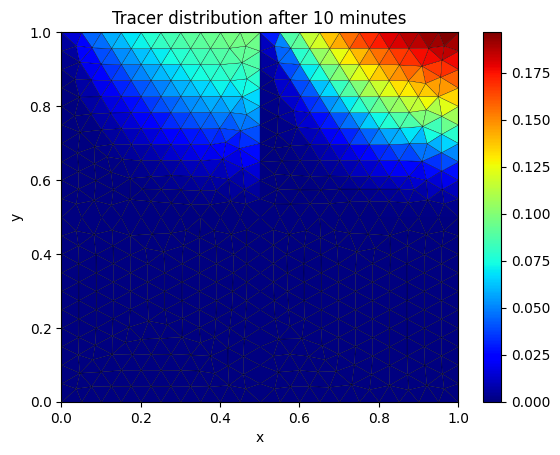

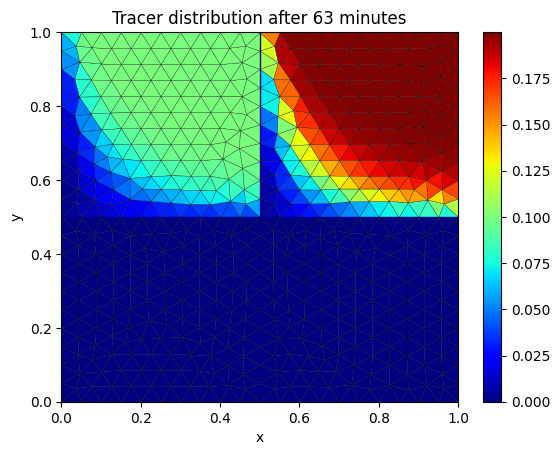

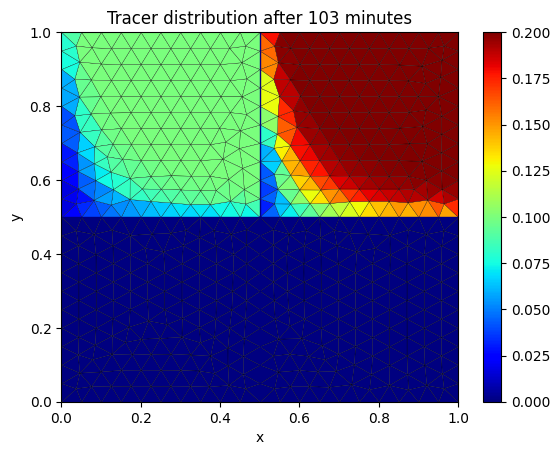

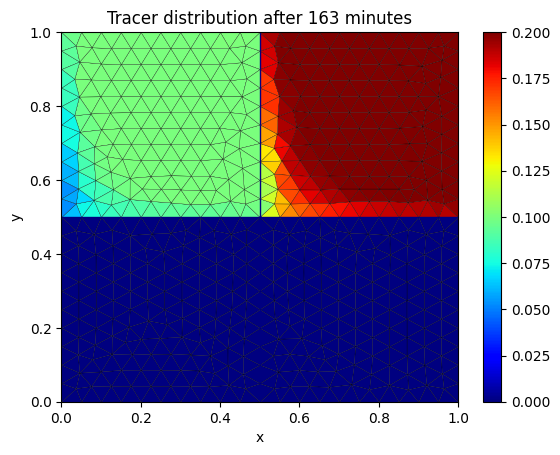

In [8]:
# initial time step 10 minutes
dt_init = 10 * pp.MINUTE
# Simulation time 5 hours
T_end = 5 * pp.HOUR
# min max time step size is 1 minute and 20 minutes respectively
dt_min_max = (0.1 * dt_init, 20 * pp.MINUTE)
# parameters for Newton solver
max_iterations = 80
newton_tol = 1e-6
newton_tol_increment = newton_tol

time_manager = pp.TimeManager(
    schedule=[0, T_end],
    dt_init=dt_init,
    dt_min_max=dt_min_max,
    iter_max=max_iterations,
    iter_optimal_range=(2, 10),
    iter_relax_factors=(0.8, 1.2),
    recomp_factor=0.8,
    recomp_max=5,
)

params = {
    "material_constants": {
        # solid with impermeable fractures
        "solid": pp.SolidConstants(
            porosity=0.1, permeability=1e-7, normal_permeability=1e-19
        ),
    },
    "fracture_indices": [0, 1],
    # The respective DOFs are eliminated by default. These flags are for demonstration.
    "eliminate_reference_phase": True,
    "eliminate_reference_component": True,
    "time_manager": time_manager,
    "max_iterations": max_iterations,
    "nl_convergence_tol": newton_tol_increment,
    "nl_convergence_tol_res": newton_tol,
    "meshing_arguments": {"cell_size": 0.05},
    "grid_type": "simplex",
    "plot_schedule": [
        pp.MINUTE * i for i in range(0, 200, 50)
    ],
}

model = TracerFlowShowcase(params)
pp.run_time_dependent_model(model, params)

## Results

As shown above, the tracer concentrations reach their target values of 10 and 20% respectively,
without crossing the impermeable fractures.
The pressure profile below explains furthermore, why it would take more time to completely fill up the
sub-squares. The simulation time suffices for the purpose of this tutorial. 

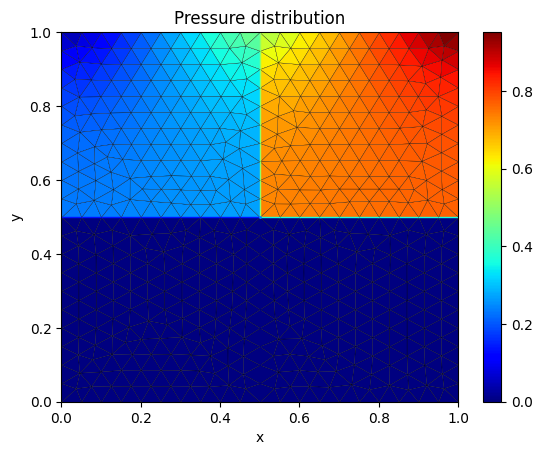

In [9]:
pp.plot_grid(
    model.mdg,
    "pressure",
    figsize=(10, 8),
    linewidth=0.2,
    title="Pressure distribution",
    plot_2d=True,
)

## What we have explored

1. We have shown how to create a 2-component fluid.
2. We have explored the relevant building blocks for a single-phase, 2-component isothermal flow model with heuristic thermodynamic properties.
3. We have shown the parallels between the mathematical model and representations of individual aspects as PorePy classes.
4. The extension to multi-component fluids is trivial. Just add more components and respective IC & BC.
   At some points you might want to think about more complex constitutive laws for fluid properties, which take
   the components into account.